# Tabular Modeling Deep Dive

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns.

In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

from fastbook import *


## Categorical Embeddings

In tabular data some columns may contain numerical data, like "age," while others contain string values, like "sex." The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers.


In [4]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [3]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [4]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [5]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

/tmp/ipykernel_61205/2252637013.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)


In [9]:
df['ProductSize'].unique()

[NaN, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [11]:
df['Differential_Type'].unique(), df['ProductGroup'].unique()

(array(['Standard', nan, 'Limited Slip', 'No Spin', 'Locking'], dtype=object),
 array(['WL', 'SSL', 'TEX', 'BL', 'TTT', 'MG'], dtype=object))

In [13]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])
df[dep_var]

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259131
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 412698, dtype: float64

In [6]:
from fastai.tabular.all import *

# df = add_datepart(df, 'saledate')

In [17]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [19]:
procs = [Categorify, FillMissing]

In [22]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

AttributeError: 'tuple' object has no attribute 'shape'

In [24]:
cont_cat_split??
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
cont,cat

(['SalesID',
  'MachineID',
  'ModelID',
  'datasource',
  'auctioneerID',
  'YearMade',
  'MachineHoursCurrentMeter',
  'saleYear',
  'saleMonth',
  'saleWeek',
  'saleDay',
  'saleDayofweek',
  'saleDayofyear',
  'saleElapsed'],
 ['UsageBand',
  'fiModelDesc',
  'fiBaseModel',
  'fiSecondaryDesc',
  'fiModelSeries',
  'fiModelDescriptor',
  'ProductSize',
  'fiProductClassDesc',
  'state',
  'ProductGroup',
  'ProductGroupDesc',
  'Drive_System',
  'Enclosure',
  'Forks',
  'Pad_Type',
  'Ride_Control',
  'Stick',
  'Transmission',
  'Turbocharged',
  'Blade_Extension',
  'Blade_Width',
  'Enclosure_Type',
  'Engine_Horsepower',
  'Hydraulics',
  'Pushblock',
  'Ripper',
  'Scarifier',
  'Tip_Control',
  'Tire_Size',
  'Coupler',
  'Coupler_System',
  'Grouser_Tracks',
  'Hydraulics_Flow',
  'Track_Type',
  'Undercarriage_Pad_Width',
  'Stick_Length',
  'Thumb',
  'Pattern_Changer',
  'Grouser_Type',
  'Backhoe_Mounting',
  'Blade_Type',
  'Travel_Controls',
  'Differential_Type',
  

In [25]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [26]:
len(to.train),len(to.valid)

(404710, 7988)

In [27]:
TabularPandas??

In [28]:
#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], ['fiBaseModel'], y_names=dep_var, splits=splits)
to1.show(5)

,state,ProductGroup,Drive_System,Enclosure,fiBaseModel,SalePrice
0,Alabama,WL,#na#,EROPS w AC,521,11.097410
1,North Carolina,WL,#na#,EROPS w AC,950,10.950807
2,New York,SSL,#na#,OROPS,226,9.210340
3,Texas,TEX,#na#,EROPS w AC,PC120,10.558414
4,New York,SSL,#na#,EROPS,S175,9.305651


In [32]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [31]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [33]:
save_pickle(path/'to.pkl',to)
# to = (path/'to.pkl').load()

In [12]:
#hide
# this loads pickled object if kernel dies.
to = load_pickle(path/'to.pkl')

In [13]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
len(xs), len(y)
samp_idx = np.random.permutation(len(y))[:500]

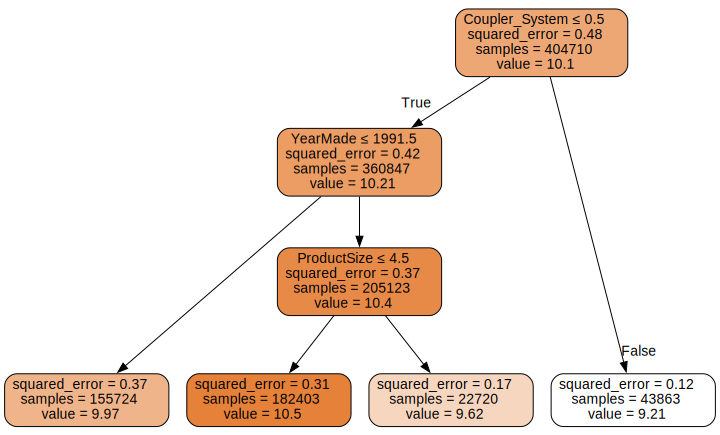

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [15]:
# !pip install -Uqq dtreeviz
# visualize decision tree
import dtreeviz
dep_var = 'SalePrice'

samp_idx = np.random.permutation(len(y))[:500]
viz_model = dtreeviz.model(m,
               X_train=xs.iloc[samp_idx],
               y_train=y.iloc[samp_idx],
               feature_names=xs.columns,
               target_name=dep_var)

# dtreeviz.model(m, X_trainxs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


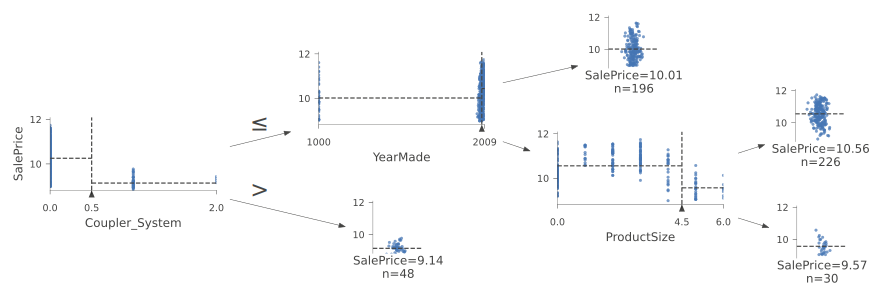

In [16]:
viz_model.view(scale=1.6, orientation='LR', fontname='DejaVu Sans', label_fontsize=10)


In [17]:

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [18]:
xs,y = to.train.xs,to.train.y

m_rmse(m, xs, y)

0.55325

In [19]:
m_rmse(m, valid_xs, valid_y)

0.55646

In [20]:
m.get_n_leaves()

4

In [34]:
xs,y = to.train.xs,to.train.y
# print(xs,y)
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.211677, 0.268089, 0.211107)

In [22]:
'''
n_estimators - number of decision trees to create in random forest.
max_samples - max. number of rows to sample for training each tree.
max_features - max. ratio of columns to sample at each binary split.
min_samples_leaf - min. amount of samples per leaf node.
'''
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [23]:
# rf_model = rf(xs, y);
# save_pickle(path/'rf_model.pkl',rf_model)
rf_model = load_pickle(path/'rf_model.pkl')

In [35]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), r_mse(rf_model.oob_prediction_, y)
# valid_xs.columns.tolist()

(0.211677, 0.268089, 0.211107)

In [25]:
#hide
preds = np.stack([t.predict(valid_xs) for t in rf_model.estimators_])


/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-pac

In [26]:
preds.shape

(40, 7988)

In [27]:
preds_std = preds.std(0)
preds_std[:5]

array([0.31865899, 0.13626066, 0.08452598, 0.2605348 , 0.09774961])

In [28]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [29]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
30,Coupler_System,0.223437
57,YearMade,0.186767
6,ProductSize,0.136330
7,fiProductClassDesc,0.119944
54,ModelID,0.096287
65,saleElapsed,0.073991
3,fiSecondaryDesc,0.031184
1,fiModelDesc,0.030080
12,Enclosure,0.024879
52,SalesID,0.019191


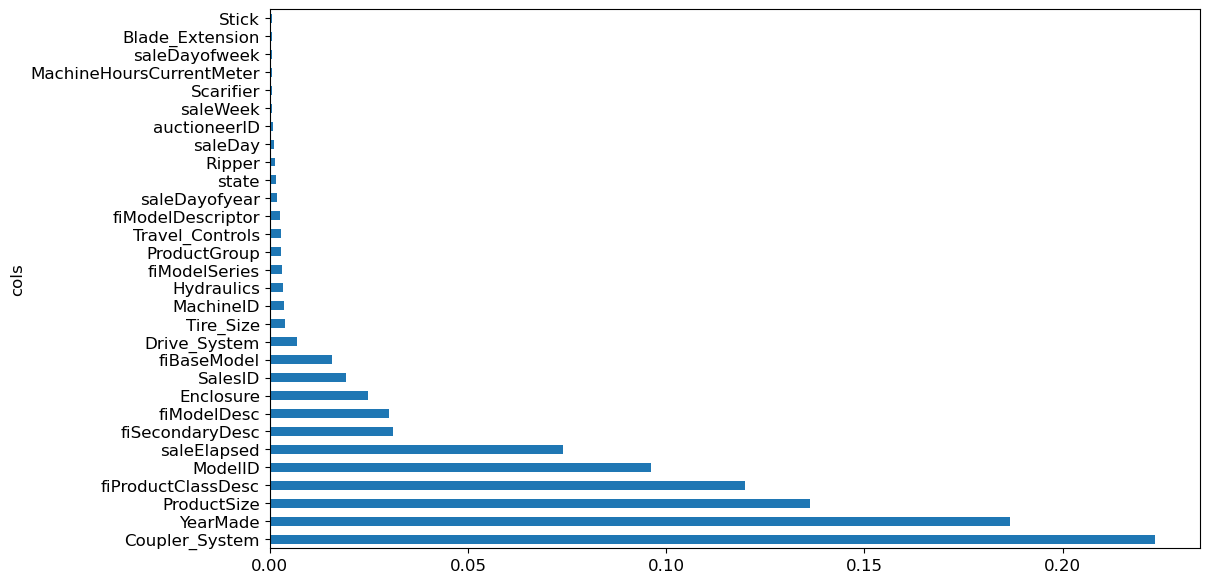

In [30]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [33]:
r_mse(rf_model.oob_prediction_, y)

0.211107

In [38]:
preds = np.stack([t.predict(valid_xs) for t in rf_model.estimators_])
preds_std[:5]

/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/mambaforge/lib/python3.10/site-pac

array([0.31865899, 0.13626066, 0.08452598, 0.2605348 , 0.09774961])

In [31]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [40]:
fi = rf_feat_importance(rf_model, xs)
fi[:10]

,cols,imp
57,YearMade,0.179870
6,ProductSize,0.124337
30,Coupler_System,0.115388
7,fiProductClassDesc,0.073877
54,ModelID,0.051503
65,saleElapsed,0.049088
3,fiSecondaryDesc,0.044128
32,Hydraulics_Flow,0.043310
31,Grouser_Tracks,0.032995
12,Enclosure,0.031745


In [41]:
to_keep = fi[fi.imp>0.005].cols
to_keep

57              YearMade
6            ProductSize
30        Coupler_System
7     fiProductClassDesc
54               ModelID
65           saleElapsed
3        fiSecondaryDesc
32       Hydraulics_Flow
31        Grouser_Tracks
12             Enclosure
1            fiModelDesc
9           ProductGroup
52               SalesID
2            fiBaseModel
59              saleYear
10      ProductGroupDesc
53             MachineID
5      fiModelDescriptor
23            Hydraulics
28             Tire_Size
11          Drive_System
Name: cols, dtype: object

In [43]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
# xs_imp, valid_xs_imp

In [44]:
new_rf_model = rf(xs_imp, y)

In [45]:
m_rmse(new_rf_model, xs_imp, y), m_rmse(new_rf_model, valid_xs_imp, valid_y)

(0.181304, 0.232254)

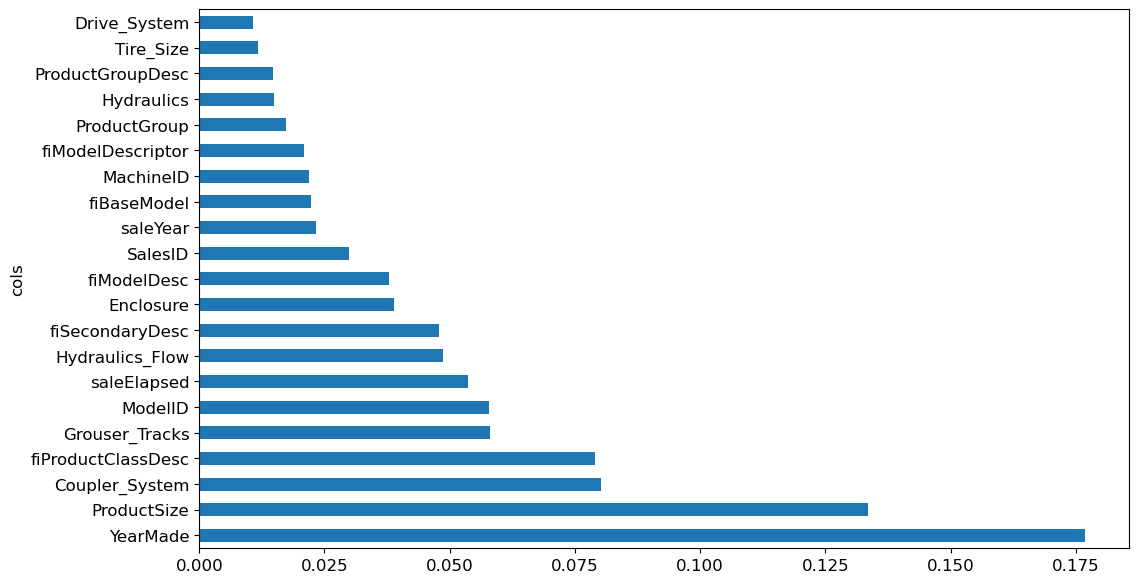

In [46]:
plot_fi(rf_feat_importance(new_rf_model, xs_imp));

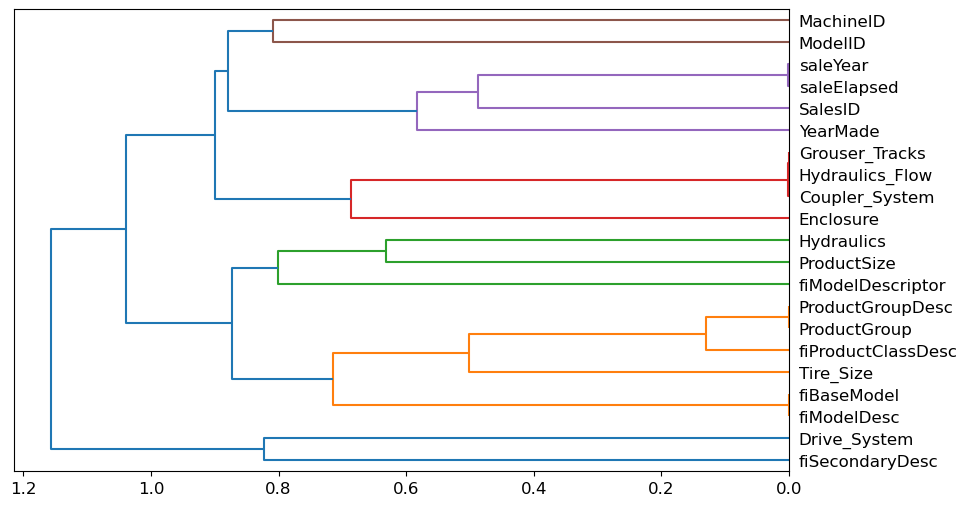

In [48]:
cluster_columns(xs_imp)
doc(cluster_columns)

In [49]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [50]:
get_oob(xs_imp)

0.876912471262369

In [51]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8770364580292673,
 'saleElapsed': 0.8728524984267785,
 'ProductGroupDesc': 0.8771560201419415,
 'ProductGroup': 0.8772390537273813,
 'fiModelDesc': 0.8760055885880194,
 'fiBaseModel': 0.8763869245379877,
 'Hydraulics_Flow': 0.8774533270272009,
 'Grouser_Tracks': 0.8777735682885348,
 'Coupler_System': 0.8774637062036257}

In [52]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8745619316607027

In [58]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

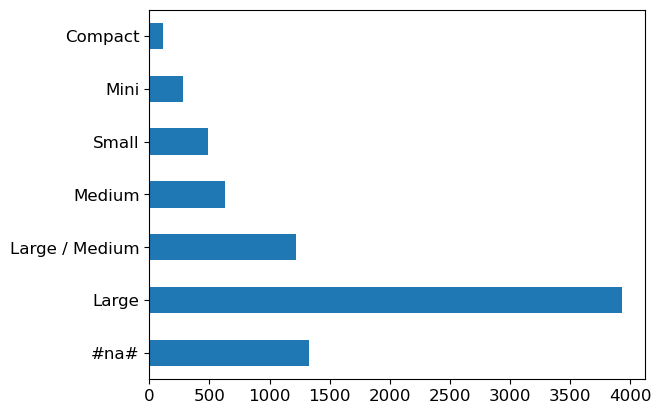

In [56]:
to_keep = fi[fi.imp>0.005].cols
valid_xs_imp = valid_xs[to_keep]
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

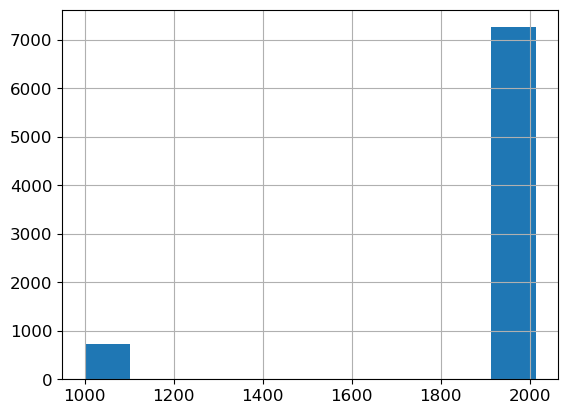

In [59]:
ax = valid_xs_final['YearMade'].hist()

In [62]:
# !pip install -U scikit-learn --user


from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/root/mambaforge/lib/python3.10/site-packages/sklearn/inspection/__init__.py)

Check whether the accuracy of the model is too good to be true.
Look for important predictors that don't make sense in practice.
Look for partial dependence plot results that don't make sense in practice.
Thinking back to our bear detector, this mirrors the advice that we provided in <>—it is often a good idea to build a model first and then do your data cleaning, rather than vice versa. The model can help you identify potentially problematic data issues.

In [76]:
xs_final = xs_imp.drop(to_drop, axis=1)
m = rf(xs_final, y)


In [64]:
!pip install treeinterpreter
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3387 sha256=99ffee0a9fd1613b7843dabcc40dbac9f13504352edf830e9cb1905db102fd16
  Stored in directory: /root/.cache/pip/wheels/bb/d9/81/e38982fda52e959cda08d83dc3982f91679a8d7e01f60ca4d9
Successfully built waterfallcharts


In [77]:
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [78]:
rows = valid_xs_final.iloc[:5]
rows.values

array([[1.0000000e+03, 3.0000000e+00, 0.0000000e+00, 4.8000000e+01, 4.1240000e+03, 1.3176000e+09, 4.3000000e+01, 0.0000000e+00, 1.0000000e+00, 2.3010000e+03, 5.0000000e+00, 1.2188220e+06,
        1.0246520e+06, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [2.0060000e+03, 0.0000000e+00, 0.0000000e+00, 2.0000000e+00, 2.4808000e+04, 1.3178592e+09, 5.0000000e+01, 0.0000000e+00, 6.0000000e+00, 2.7800000e+02, 1.0000000e+00, 1.2188230e+06,
        1.0676010e+06, 1.7000000e+01, 0.0000000e+00, 0.0000000e+00, 2.0000000e+00],
       [2.0060000e+03, 0.0000000e+00, 2.0000000e+00, 4.1000000e+01, 9.5800000e+03, 1.3178592e+09, 0.0000000e+00, 3.0000000e+00, 6.0000000e+00, 4.5140000e+03, 3.0000000e+00, 1.2188240e+06,
        1.0105820e+06, 0.0000000e+00, 4.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [2.0030000e+03, 0.0000000e+00, 2.0000000e+00, 4.4000000e+01, 6.2700000e+03, 1.3178592e+09, 0.0000000e+00, 3.0000000e+00, 6.0000000e+00, 4.2130000e+03, 3.0000000e+00, 1.2188250e+

In [74]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [79]:
prediction,bias,contributions = treeinterpreter.predict(m, rows.values)
prediction[0], bias[0], contributions[0].sum()

(array([9.96608845]), 10.104403498584746, -0.13831504470110959)

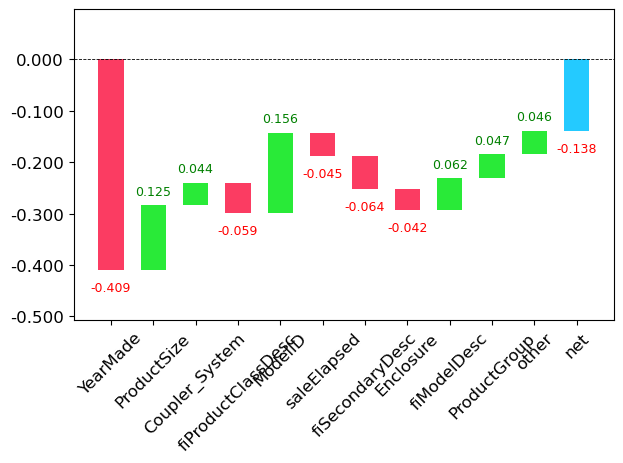

In [80]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [81]:
np.random.seed(42)

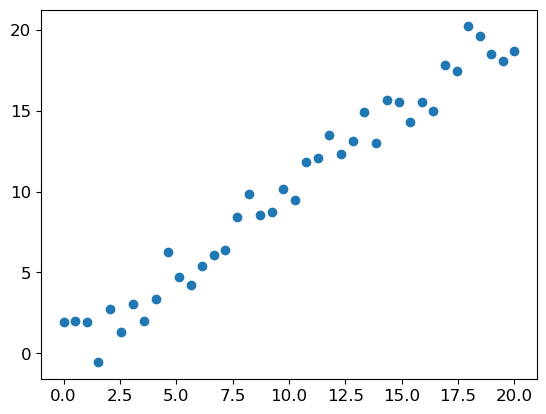

In [82]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [83]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [85]:
x_lin, torch.randn_like(x_lin)

(tensor([ 0.0000,  0.5128,  1.0256,  1.5385,  2.0513,  2.5641,  3.0769,  3.5897,  4.1026,  4.6154,  5.1282,  5.6410,  6.1538,  6.6667,  7.1795,  7.6923,  8.2051,  8.7179,  9.2308,  9.7436, 10.2564,
         10.7692, 11.2821, 11.7949, 12.3077, 12.8205, 13.3333, 13.8462, 14.3590, 14.8718, 15.3846, 15.8974, 16.4103, 16.9231, 17.4359, 17.9487, 18.4615, 18.9744, 19.4872, 20.0000]),
 tensor([-1.4570, -0.1023, -0.5992,  0.4771,  0.7262,  0.0912, -0.3891,  0.5279, -0.0127,  0.2408,  0.1325,  0.7642,  1.0950,  0.3399,  0.7200,  0.4114,  1.9312,  1.0119, -1.4364, -1.1299, -0.1360,
          1.6354,  0.6547,  0.5760,  1.0414, -0.3997, -2.2933,  0.4976, -0.4257, -1.3371, -0.1933,  0.6526, -0.3063, -0.3302, -0.9808,  0.1947, -1.6535,  0.6814,  1.4611, -0.3098]))

In [90]:
# torch.randn_like??
plt.scatter??

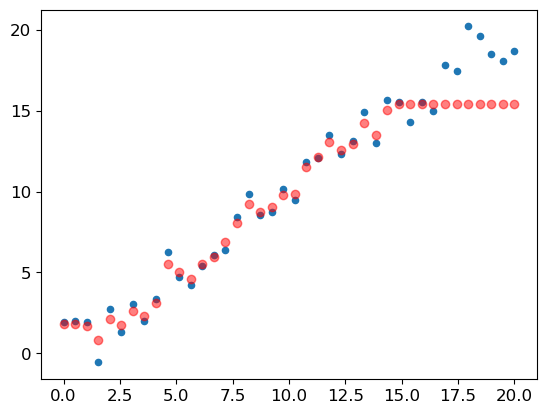

In [88]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [91]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.856673
11,SalesID,0.109534
12,MachineID,0.025727
0,YearMade,0.002831
4,ModelID,0.001247
8,Enclosure,0.000774


In [94]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232106
SalesID 0.230855
saleElapsed 0.235484
MachineID 0.231039


In [95]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229883

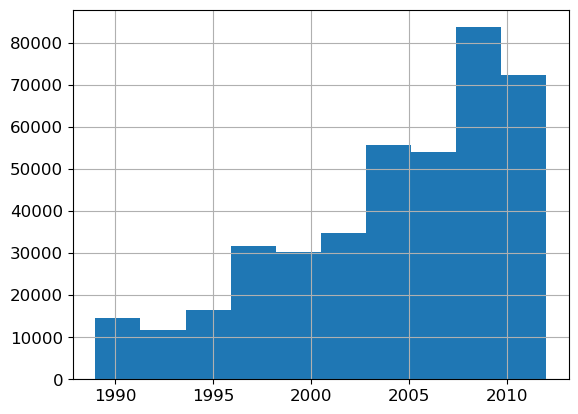

In [96]:
xs['saleYear'].hist();

In [98]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

orig 0.232511


(0.177367, 0.22889)

In [102]:
from fastai.tabular.all import *

sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [112]:
#hide
# list(xs_final_time.columns) + [dep_var]
df_nn

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,9.210340,1919201,21435,149,2.0,2005,NaN,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2012,3,10,7,2,67,False,False,False,False,False,False,1.331078e+09
412694,6333345,9.259131,1882122,21436,149,2.0,2005,NaN,NaN,30NX2,30,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,N

In [104]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [105]:
cont_nn,cat_nn

(['saleElapsed'],
 ['YearMade',
  'ProductSize',
  'Coupler_System',
  'fiProductClassDesc',
  'ModelID',
  'fiSecondaryDesc',
  'Hydraulics_Flow',
  'Enclosure',
  'fiModelDesc',
  'ProductGroup',
  'fiModelDescriptor',
  'Hydraulics',
  'Tire_Size',
  'Drive_System'])

In [106]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
Enclosure                6
fiModelDesc           5059
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Tire_Size               17
Drive_System             4
dtype: int64

In [113]:
cont_nn

['saleElapsed']

In [115]:
xs_filt2 = xs_filt.drop('fiModelDesc', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDesc', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.180523, 0.232354)

In [116]:
cat_nn.remove('fiModelDescriptor')
cat_nn

['YearMade',
 'ProductSize',
 'Coupler_System',
 'fiProductClassDesc',
 'ModelID',
 'fiSecondaryDesc',
 'Hydraulics_Flow',
 'Enclosure',
 'fiModelDesc',
 'ProductGroup',
 'Hydraulics',
 'Tire_Size',
 'Drive_System']

In [120]:
procs_nn = [Categorify, FillMissing, Normalize]
cond = (df_nn.saleYear<2011) | (df_nn.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [124]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

In [128]:
dls = to_nn.dataloaders(1024)
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0004786300996784121)

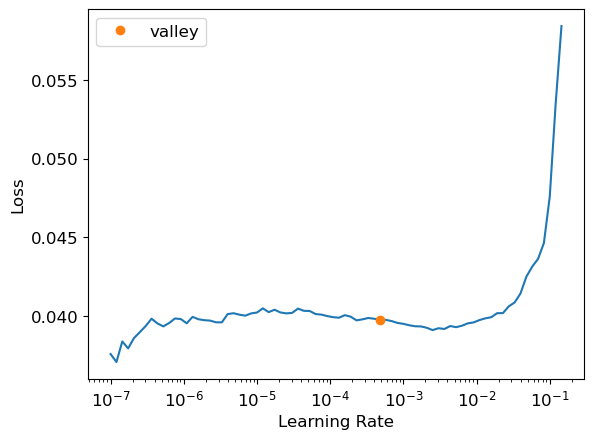

In [131]:
learn.lr_find()

In [137]:
lr = 0.0004786300996784121
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,time
0,0.038926,0.052832,00:37
1,0.039316,0.051371,00:42
2,0.039406,0.052378,00:43
3,0.039239,0.053732,00:40
4,0.039126,0.051814,00:41
5,0.038359,0.052741,00:41
6,0.038537,0.052467,00:41
7,0.037793,0.052058,00:40
8,0.037822,0.052619,00:40
9,0.037317,0.052422,00:41


In [138]:
preds,targs = learn.get_preds()
preds,targs

(tensor([[10.2191],
         [10.0652],
         [ 9.3609],
         ...,
         [ 9.3017],
         [ 9.2528],
         [ 9.2528]]),
 tensor([[10.0432],
         [10.0858],
         [ 9.3927],
         ...,
         [ 9.3501],
         [ 9.1050],
         [ 8.9554]]))

In [139]:
r_mse(preds,targs)

0.228958

In [140]:
learn.save('nn')

Path('models/nn.pth')

In [141]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [142]:
r_mse(ens_preds,valid_y)

0.22353

In [144]:
r_mse(rf_preds,valid_y)

0.22889